In [15]:
import xarray as xr
import matplotlib.pyplot as plt
import glob
from thesis_toolbox.plot.plot_source_contribution import depositon_facet_plot
from matplotlib.colors import LogNorm
from matplotlib import rc
import matplotlib
import matplotlib.cm as cm
import cartopy.crs as ccrs
import numpy as np
from dust.plot.maps import map_china
from dust.plot.plotting import mpl_base_map_plot_xr
from thesis_toolbox.utils import get_locations_CLP
def preproc(ds):
    da = ds['surface_sensitivity']
    da = da.expand_dims('site')
    if ds.attrs['relcom'][0] == 'BADOE':
        s = ['BAODE']
    else:
        s = [ds.attrs['relcom'][0]]
        
    da = da.assign_coords(site=s)
    da.attrs = {**da.attrs,**{'lat0':float(ds['RELLAT1'].values),'lon0':float(ds['RELLNG1'].values)}}
    return da.to_dataset().resample(time='Y').mean(keep_attrs=True)

In [22]:
footprint_wetdep2m = xr.open_mfdataset(
    snakemake.input.footprint_files_wetdep2m, preprocess=preproc, concat_dim=['site'], combine='nested'        
)
footprint_wetdep2m = footprint_wetdep2m.mean(dim='time',keep_attrs=True)
footprint_drydep2m = xr.open_mfdataset(
    snakemake.input.footprint_files_drydep2m, preprocess=preproc, concat_dim=['site'], combine='nested'        
)
footprint_drydep2m = footprint_drydep2m.mean(dim='time',keep_attrs=True)

footprint_wetdep20m = xr.open_mfdataset(
    snakemake.input.footprint_files_wetdep20m, preprocess=preproc, concat_dim=['site'], combine='nested'        
)
footprint_wetdep20m = footprint_wetdep20m.mean(dim='time', keep_attrs=True)

footprint_drydep20m = xr.open_mfdataset(
    snakemake.input.footprint_files_drydep20m, preprocess=preproc,concat_dim=['site'], combine='nested')

footprint_drydep20m = footprint_drydep20m.mean(dim='time',keep_attrs=True)

footprint_dsets = [footprint_drydep2m.compute(), footprint_wetdep2m.compute(), 
                   footprint_drydep20m.compute(), footprint_wetdep20m.compute()]

In [16]:
locs = ['SHAPOTOU','SACOL','BAODE','LUOCHUAN','LINGTAI','LANTIAN']
locations_df = get_locations_CLP() 

In [26]:
cm1 = ['#AA42BD','#E3EBB7','#2CC734']#2CC734
nodes = [0.0,0.5,1.0]
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("cmap2", list(zip(nodes,cm1)))
cmap2.set_over('#228F32')

In [32]:
cmap = cm.YlOrBr

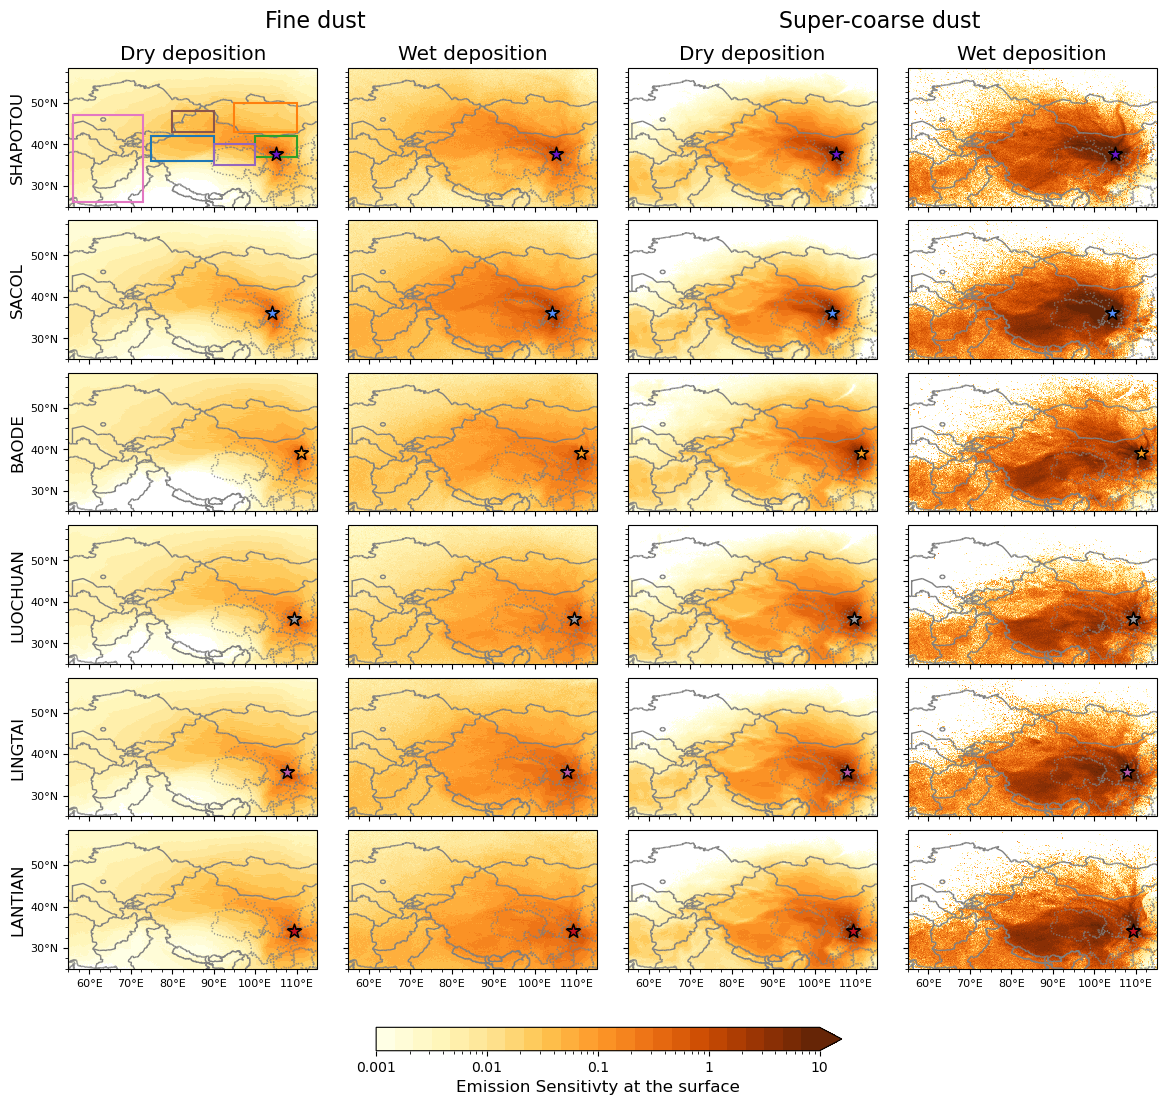

In [39]:
cmap = cmap.resampled(24)
fig,ax = plt.subplots(nrows=6, ncols=4,  figsize=(8.3*1.7, 11.7), subplot_kw={'projection':ccrs.PlateCarree()})
for i,s in enumerate(locs):
    axi = ax[i,:]
    for axj in axi.ravel():
        map_china(axj)
    j=0
    for axj, ds, title in zip(axi.ravel(),footprint_dsets, ['Dry', 'Wet', 'Dry', 'Wet']):
        if i == 0:
            axj.set_title(f'{title} deposition')

        vmin=1e-4; vmax=1e1
        temp_d = ds.sel(site=s)['surface_sensitivity']
        
        mpl_base_map_plot_xr(temp_d,ax = axj,colorbar=False, vmin=vmin, vmax=vmax,add_labels=False,
                             extend='max', cmap=cmap)
        axj.scatter(locations_df.loc[s,:][0],
                        locations_df.loc[s,:][1],marker='*', 
                        color=locations_df.loc[s,:]['color'], zorder=1300,  edgecolors='black',
                        linewidth=1.1, s=110)
        j+=1

for axi in ax.ravel():
    axi.set_extent([55,115,25,55])
    axi.set_xticks([60,70, 80, 90, 100, 110])
    axi.yaxis.set_ticklabels([])
    axi.xaxis.set_ticklabels([])
for axi,l in zip(ax[:,0].ravel(),locs):
    axi.set_ylabel(l)
    axi.set_yticks([30, 40, 50])
    axi.yaxis.set_ticklabels(['30°N', '40°N', '50°N'], fontsize=8)

for axi in ax[-1,:].ravel():
    axi.set_xticks([60,70, 80, 90, 100, 110])
    axi.xaxis.set_ticklabels(['60°E','70°E','80°E', '90°E', '100°E', '110°E'], fontsize=8)

cax = fig.add_axes([0.345, 0.04,0.33,0.02])
cb = fig.colorbar(cm.ScalarMappable(norm=matplotlib.colors.LogNorm(1e-2, 100), cmap=cmap), cax=cax,
            label='Emission Sensitivty at the surface', orientation='horizontal', ticks=[0.01, 0.1, 1, 10, 100],  extend='max')
cb.ax.set_xticklabels([0.001,0.01, 0.1, 1, 10])
fig.suptitle('Fine dust                                                          Super-coarse dust',x=0.52, y=0.92, ha='center', va='center', fontsize=16)
ax_i = ax[0,0] 
ax_i.add_patch(matplotlib.patches.Rectangle(xy=[75,36],width=15,height=6, transform=ccrs.PlateCarree(),
                                            fill=False,linewidth=1.5, edgecolor='tab:blue',zorder=2000))
ax_i.add_patch(matplotlib.patches.Rectangle(xy=[100,37],width=10,height=5, transform=ccrs.PlateCarree(),
                                            fill=False,linewidth=1.5, edgecolor='tab:green',zorder=1250))
ax_i.add_patch(matplotlib.patches.Rectangle(xy=[95,43],width=15,height=7, transform=ccrs.PlateCarree(),
                                            fill=False,linewidth=1.5, edgecolor='tab:orange',zorder=2000))
ax_i.add_patch(matplotlib.patches.Rectangle(xy=[80,43],width=10,height=5, transform=ccrs.PlateCarree(),
                                            fill=False,linewidth=1.5, edgecolor='tab:brown',zorder=2000))
ax_i.add_patch(matplotlib.patches.Rectangle(xy=[90,35],width=10,height=5, transform=ccrs.PlateCarree(),
                                            fill=False,linewidth=1.5, edgecolor='tab:purple',zorder=2000))
ax_i.add_patch(matplotlib.patches.Rectangle(xy=[56,26],width=17,height=21, transform=ccrs.PlateCarree(),
                                            fill=False,linewidth=1.5, edgecolor='tab:pink', zorder=2000))



fig.subplots_adjust(hspace=0.1, wspace=0.1)
if 'snakemake' in globals():
    plt.savefig(snakemake.output.facet_plot_footprint,bbox_inches='tight', dpi=300)